In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader

import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class VectorGenerator:
    def __init__(self, max_val = 10):
        self.max_val = np.abs(max_val)
    def gen_data(self):
        x1 = np.random.rand(2)*self.max_val*2-self.max_val
        x2 = np.random.rand(2)*self.max_val*2-self.max_val
        x3 = np.random.rand(2)*self.max_val*2-self.max_val
        x = np.concatenate((x1,x2,x3), axis=0).astype(np.float32)
        return x
        
class NonLinearFuncDataset(Dataset):
    def __init__(self, max_val = 10):
        self.generator = VectorGenerator(max_val = 10)
        
    def __getitem__(self, index):
        x = self.generator.gen_data()
        y = (np.cos(np.abs(np.mean(x))**1.5 + 0.25*np.mean(x)**2)+1)/2
        return x, y
    
    def __len__(self):
        return 1000000

In [3]:
class BetaNN(nn.Module):
    def __init__(self, mid=10):
        super(BetaNN, self).__init__()
        self.fc1 = nn.Linear(6, mid)
        self.fc2 = nn.Linear(mid, mid)
        self.fc3 = nn.Linear(mid, mid)
        self.fc_a = nn.Linear(mid, 1)
        self.fc_b = nn.Linear(mid, 1)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.cos(self.fc3(x))
        a = F.softplus(self.fc_a(x)).squeeze(1)
        b = F.softplus(self.fc_b(x)).squeeze(1)
        y = (a/(a+b))
        gamma = a+b
        return y,gamma

class LinearNN(nn.Module):
    def __init__(self, mid=10):
        super(LinearNN, self).__init__()
        self.fc1 = nn.Linear(6, mid)
        self.fc2 = nn.Linear(mid, mid)
        self.fc3 = nn.Linear(mid, mid)
        self.fcy = nn.Linear(mid, 1)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.cos(self.fc3(x))
        y = F.relu(self.fcy(x)).squeeze(1)
        return y

class SigmoidNN(nn.Module):
    def __init__(self, mid=10):
        super(SigmoidNN, self).__init__()
        self.fc1 = nn.Linear(6, mid)
        self.fc2 = nn.Linear(mid, mid)
        self.fc3 = nn.Linear(mid, mid)
        self.fcy = nn.Linear(mid, 1)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.cos(self.fc3(x))
        y = F.sigmoid(self.fcy(x)).squeeze(1)
        return y
    
def beta_loss(y_hat, gamma , y_true):
    a = y_hat*gamma
    b = gamma - a
    tmp1 = (a-1)*torch.lgamma(y_true)
    tmp2 = (b-1)*torch.lgamma(y_true)
    tmp3 = torch.lgamma(a+b)-torch.lgamma(a)-torch.lgamma(b)
    return torch.exp(-torch.sum(tmp1+tmp2+tmp3)*0.01)

In [4]:
beta_nn = BetaNN(mid=10)
optimizer = optim.SGD(beta_nn.parameters(), lr=0.05)

beta_nn_ml = BetaNN(mid=10)
optimizer1 = optim.SGD(beta_nn.parameters(), lr=0.05)

linear_nn = LinearNN(mid=10)
optimizer2 = optim.SGD(linear_nn.parameters(), lr=0.05)

sigmoid_nn = SigmoidNN(mid=10)
optimizer3 = optim.SGD(sigmoid_nn.parameters(), lr=0.05)

sigmoid_nn_l1 = SigmoidNN(mid=10)
optimizer4 = optim.SGD(sigmoid_nn.parameters(), lr=0.05)

train_dataset = NonLinearFuncDataset(max_val = 3)
train_loader = DataLoader(dataset = train_dataset, batch_size = 12)
train_iter = iter(train_loader)

In [5]:
loss_buf = 0
loss_buf1 = 0
loss_buf2 = 0
loss_buf3 = 0
loss_buf4 = 0

loss_track = []
loss_track1 = []
loss_track2 = []
loss_track3 = []
loss_track4 = []

print_iter = 100
stop_iter = 10000
i = 0

In [6]:
while 1:
    x, y_true = next(train_iter)
    
    beta_nn.train()
    y_hat, gamma = beta_nn(x)
    loss = F.l1_loss(y_hat, y_true)
    loss.backward()
    loss_buf += loss.detach()
    optimizer.step()
    optimizer.zero_grad()
    
    beta_nn_ml.train()
    y_hat1, gamma1 = beta_nn_ml(x)
    loss1 = beta_loss(y_hat1, gamma1 , y_true)
    loss1.backward()
    loss_buf1 += F.l1_loss(y_hat1, y_true).detach()
    optimizer1.step()
    optimizer1.zero_grad()
    
    linear_nn.train()
    y_hat2 = linear_nn(x)
    loss2 = F.l1_loss(y_hat2, y_true)
    loss2.backward()
    loss_buf2 += loss2.detach()
    optimizer2.step()
    optimizer2.zero_grad()

    sigmoid_nn.train()
    y_hat3 = sigmoid_nn(x)
    loss3 = F.binary_cross_entropy(y_hat3, y_true)
    loss3.backward()
    loss_buf3 += F.l1_loss(y_hat3, y_true).detach()
    optimizer3.step()
    optimizer3.zero_grad()
    
    sigmoid_nn_l1.train()
    y_hat4 = sigmoid_nn_l1(x)
    loss4 = F.l1_loss(y_hat4, y_true)
    loss4.backward()
    loss_buf4 += loss4.detach()
    optimizer4.step()
    optimizer4.zero_grad()   
    
    if i%print_iter==0 and i>0:
        loss_track += [loss_buf.item()/print_iter]
        loss_track1 += [loss_buf1.item()/print_iter]
        loss_track2 += [loss_buf2.item()/print_iter]
        loss_track3 += [loss_buf3.item()/print_iter]
        loss_track4 += [loss_buf4.item()/print_iter]
        print('beta: ', loss_track[-1], y_hat.mean().item(), y_true.mean().item())
        print('beta_ml: ', loss_track1[-1], y_hat1.mean().item(), y_true.mean().item())
        print('line: ', loss_track2[-1], y_hat2.mean().item(), y_true.mean().item())
        print('sigm: ', loss_track3[-1], y_hat3.mean().item(), y_true.mean().item())
        print('sil1: ', loss_track4[-1], y_hat4.mean().item(), y_true.mean().item())
        print('-')
        loss_buf = 0
        loss_buf1 = 0
        loss_buf2 = 0
        loss_buf3 = 0
        loss_buf4 = 0
    
    i += 1
    if i>=stop_iter:
        break

c:\users\administrator\appdata\local\programs\python\python35\lib\site-packages\torch\nn\functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


beta:  0.33582027435302736 0.6246938109397888 0.652942955493927
beta_ml:  0.35990009307861326 0.39805352687835693 0.652942955493927
line:  0.3752695083618164 0.6844403743743896 0.652942955493927
sigm:  0.33180713653564453 0.5745254755020142 0.652942955493927
sil1:  0.36475914001464843 0.3892507255077362 0.652942955493927
-
beta:  0.3092766189575195 0.6787131428718567 0.6939852833747864
beta_ml:  0.3617866897583008 0.40179917216300964 0.6939852833747864
line:  0.3210963821411133 0.7991657257080078 0.6939852833747864
sigm:  0.31594297409057615 0.6164960861206055 0.6939852833747864
sil1:  0.36366016387939454 0.41435229778289795 0.6939852833747864
-
beta:  0.32752262115478514 0.6197183132171631 0.5784254670143127
beta_ml:  0.3610039520263672 0.3906342685222626 0.5784254670143127
line:  0.3377079010009766 0.7091891169548035 0.5784254670143127
sigm:  0.3294591522216797 0.5504841804504395 0.5784254670143127
sil1:  0.3649877166748047 0.4058040380477905 0.5784254670143127
-
beta:  0.31579038619

beta:  0.255237922668457 0.5834518671035767 0.6495690941810608
beta_ml:  0.3566125869750977 0.40749481320381165 0.6495690941810608
line:  0.18504753112792968 0.6512264609336853 0.6495690941810608
sigm:  0.14148752212524415 0.6688975691795349 0.6495690941810608
sil1:  0.35845504760742186 0.38609087467193604 0.6495690941810608
-
beta:  0.2467416763305664 0.48213836550712585 0.4832982122898102
beta_ml:  0.35958232879638674 0.4035389721393585 0.4832982122898102
line:  0.18711614608764648 0.4200698137283325 0.4832982122898102
sigm:  0.13500372886657716 0.482465535402298 0.4832982122898102
sil1:  0.3626021194458008 0.4082561433315277 0.4832982122898102
-
beta:  0.21806203842163085 0.6290664076805115 0.6439392566680908
beta_ml:  0.3584722137451172 0.40058502554893494 0.6439392566680908
line:  0.17473703384399414 0.5712255835533142 0.6439392566680908
sigm:  0.12812546730041505 0.6341978311538696 0.6439392566680908
sil1:  0.36182048797607425 0.38431844115257263 0.6439392566680908
-
beta:  0.190

beta:  0.1436837387084961 0.7006352543830872 0.6466410756111145
beta_ml:  0.3543119049072266 0.3885461986064911 0.6466410756111145
line:  0.13948476791381836 0.6511764526367188 0.6466410756111145
sigm:  0.1253963851928711 0.7125654816627502 0.6466410756111145
sil1:  0.3536376953125 0.3718102276325226 0.6466410756111145
-
beta:  0.14448333740234376 0.6771588325500488 0.7140185236930847
beta_ml:  0.3616644287109375 0.39736080169677734 0.7140185236930847
line:  0.14966708183288574 0.6686592698097229 0.7140185236930847
sigm:  0.1229368782043457 0.5941804051399231 0.7140185236930847
sil1:  0.36373477935791015 0.3703877031803131 0.7140185236930847
-
beta:  0.13805060386657714 0.6730435490608215 0.7634273171424866
beta_ml:  0.35945140838623046 0.4005790948867798 0.7634273171424866
line:  0.1368677520751953 0.7241125106811523 0.7634273171424866
sigm:  0.11837800025939942 0.7007080912590027 0.7634273171424866
sil1:  0.3633179473876953 0.3859524726867676 0.7634273171424866
-
beta:  0.13120802879

beta:  0.13067238807678222 0.49052777886390686 0.5830814242362976
beta_ml:  0.366912841796875 0.41168344020843506 0.5830814242362976
line:  0.11472599983215331 0.5521151423454285 0.5830814242362976
sigm:  0.10688175201416016 0.47614559531211853 0.5830814242362976
sil1:  0.36920970916748047 0.396391361951828 0.5830814242362976
-
beta:  0.12828176498413085 0.6639421582221985 0.649316668510437
beta_ml:  0.35597129821777346 0.3915194272994995 0.649316668510437
line:  0.11634062767028809 0.6305381655693054 0.649316668510437
sigm:  0.10521966934204102 0.6772594451904297 0.649316668510437
sil1:  0.3595455551147461 0.396452397108078 0.649316668510437
-
beta:  0.12298362731933593 0.6496084332466125 0.6582415699958801
beta_ml:  0.36128387451171873 0.3988609313964844 0.6582415699958801
line:  0.10588618278503419 0.6120840311050415 0.6582415699958801
sigm:  0.10164692878723144 0.6674107909202576 0.6582415699958801
sil1:  0.3646553421020508 0.39078521728515625 0.6582415699958801
-
beta:  0.12714199

Text(0.5, 1.0, 'L1 loss curve')

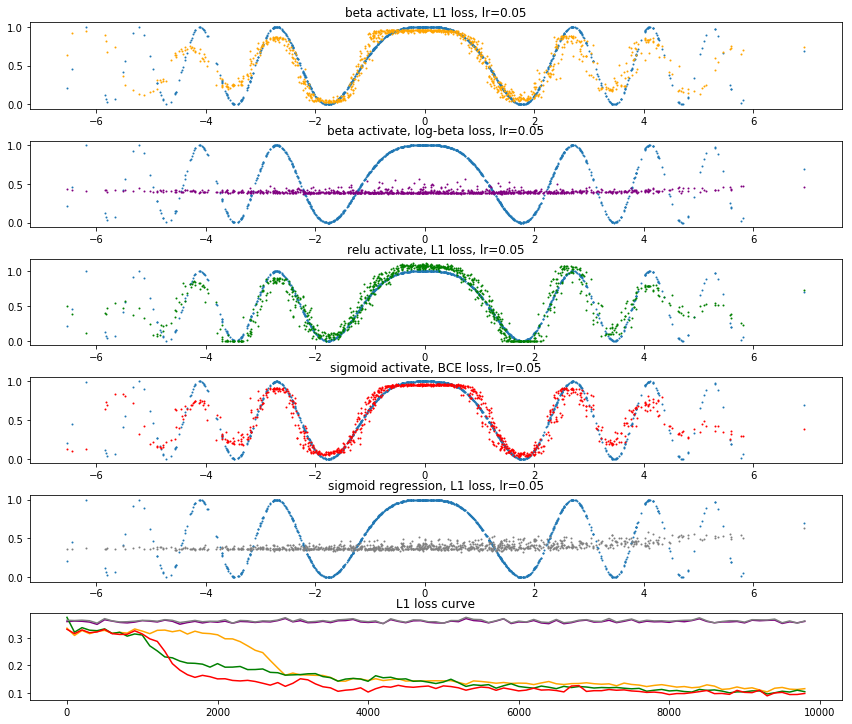

In [7]:
test_loader = DataLoader(dataset = train_dataset, batch_size = 1000)
test_iter = iter(test_loader)
beta_nn.eval()
x,y = next(test_iter)
y_hat,gamma = beta_nn(x)
y_hat1,gamma1 = beta_nn_ml(x)
y_hat2 = linear_nn(x)
y_hat3 = sigmoid_nn(x)
y_hat4 = sigmoid_nn_l1(x)
fig, axes = plt.subplots(6,1, figsize=(12,10))
plt.tight_layout()
axes[0].scatter(x.mean(1).detach().numpy(),y.detach().numpy(),s=1)
axes[0].scatter(x.mean(1).detach().numpy(),y_hat.detach().numpy(),s=1,c='orange')
axes[0].set_title('beta activate, L1 loss, lr=0.05')
axes[1].scatter(x.mean(1).detach().numpy(),y.detach().numpy(),s=1)
axes[1].scatter(x.mean(1).detach().numpy(),y_hat1.detach().numpy(),s=1,c='purple')
axes[1].set_title('beta activate, log-beta loss, lr=0.05')
axes[2].scatter(x.mean(1).detach().numpy(),y.detach().numpy(),s=1)
axes[2].scatter(x.mean(1).detach().numpy(),y_hat2.detach().numpy(),s=1,c='green')
axes[2].set_title('relu activate, L1 loss, lr=0.05')
axes[3].scatter(x.mean(1).detach().numpy(),y.detach().numpy(),s=1)
axes[3].scatter(x.mean(1).detach().numpy(),y_hat3.detach().numpy(),s=1,c='red')
axes[3].set_title('sigmoid activate, BCE loss, lr=0.05')
axes[4].scatter(x.mean(1).detach().numpy(),y.detach().numpy(),s=1)
axes[4].scatter(x.mean(1).detach().numpy(),y_hat4.detach().numpy(),s=1,c='grey')
axes[4].set_title('sigmoid regression, L1 loss, lr=0.05')
axes[5].plot(np.arange(len(loss_track))*print_iter,np.array(loss_track),c='orange')
axes[5].plot(np.arange(len(loss_track1))*print_iter,np.array(loss_track1),c='purple')
axes[5].plot(np.arange(len(loss_track2))*print_iter,np.array(loss_track2),c='green')
axes[5].plot(np.arange(len(loss_track3))*print_iter,np.array(loss_track3),c='red')
axes[5].plot(np.arange(len(loss_track4))*print_iter,np.array(loss_track4),c='grey')
axes[5].set_title('L1 loss curve')